<a href="https://colab.research.google.com/github/Jayashrita/GAMBES/blob/master/GAMBES_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Load libraries
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset

import os
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from sklearn import mixture
#import progressbar

from google.colab import files

print("Using Pytorch",torch.__version__)

Using Pytorch 1.6.0+cu101


In [2]:
#@title **Upload data**
upload_from = "Local" #@param ["Local", "GoogleDrive", "URL"]

if upload_from == "Local":
    print("================================")
    print("== Upload dataset ==")
    print("================================")
    uploaded = files.upload()
    for fn in uploaded.keys():
        !mv {fn} A.dat


elif upload_from == "GoogleDrive":
    from google.colab import drive
    drive.mount('/content/gdrive',force_remount=True)
    
    gdrive_path_state = "gdrive/My Drive/" #@param {type:"string"}
    !cp "{gdrive_path_state}" A.dat


elif upload_from == "URL":
    url_state = "" #@param {type:"string"}
    !wget -O A.dat {url_state} 

== Upload dataset ==


Saving descriptors to descriptors


In [4]:
#@title **Load files**
n_descriptors =  2#@param {type:"integer"}
from_column =  1#@param {type:"integer"}
freq_data_points= 2#@param {type:"integer"}

dist = np.loadtxt('A.dat',usecols=range(from_column,from_column+n_descriptors))

dist=dist[::freq_data_points]
print("[Imported data]")
print("- data.shape:", dist.shape)

[Imported data]
- data.shape: (33921, 2)


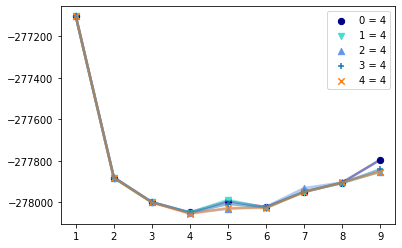

[ 1  2  3  4  5  6  7  8  9 10]


<BarContainer object of 10 artists>

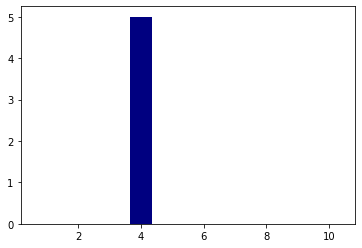

In [5]:
#@title **Fitting Gaussians**
Minimum_number_of_Gaussians =  1#@param {type:"integer"}
Maximum_number_of_Gaussians =  10#@param {type:"integer"}
Number_of_trials = 5#@param {type:"integer"}

markers=itertools.cycle(["o","v","^","+","x","d","*"])

n_trials=Number_of_trials
nc_l = Minimum_number_of_Gaussians
nc_u = Maximum_number_of_Gaussians
values=[]
X=dist
if(n_descriptors==1):
   X=X.reshape(-1, 1)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9'])
for num_trials in range(n_trials):
    
    lowest_bic = np.infty
    bic = []
    ndat= []
    n_components_range = range(nc_l,nc_u)
#cv_types = ['spherical', 'tied', 'diag', 'full']
    cv_types = ['full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,covariance_type=cv_type,max_iter=2000)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            ndat.append(n_components)
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    
    clf = best_gmm
    bars = []
    col=next(color_iter)
    mark=next(markers)
    plt.scatter(ndat,bic,label=str(num_trials)+" = "+str(len(clf.weights_)),s=40,c=col,marker=mark)
    plt.plot(ndat,bic,alpha=0.5,linewidth=2.5,c=col)
    values.append(int(len(clf.weights_)))
plt.legend()
plt.show()

h=[0 for i in range(nc_l,nc_u+1)]
v=np.arange(nc_l,nc_u+1,1)
print(v)
for i in range(len(values)):
  a=np.where(values[i]==v)[0][0]
  h[a]+=1

plt.bar(v,h,0.7,color="navy")

In [6]:
#@title **Plumed GAMBES Input**
Number_of_Gaussians =  4#@param {type:"integer"}
#Filename = 
nc=Number_of_Gaussians
d=n_descriptors

X=np.asarray(dist)
if(n_descriptors==1):
   X=X.reshape(-1, 1)

gmm = mixture.GaussianMixture(n_components=nc, covariance_type='full',max_iter=2000)
gmm.fit(X)
mu=gmm.means_
cov=gmm.covariances_
weights=gmm.weights_


print("#! FIELDS ID WEIGHTS", end=" ")
for i in range(d):
    print(" mu_%d"%i, end=" ")
for j in range(d):
    for k in range(d):
        print(" cov_%d_%d"%(j,k), end=" ")
print()
for i in range(len(weights)):
    print("%d %0.6f"%(i,weights[i]), end=" ")
    for m in mu[i]:
        print(" %0.6f"%m, end=" ")
    for j in range(d):
        for k in range(d):
            print(" %0.6f"%cov[i][j,k], end=" ")

    print()

#! FIELDS ID WEIGHTS  mu_0  mu_1  cov_0_0  cov_0_1  cov_1_0  cov_1_1 
0 0.147233  0.312193  2.521784  0.000585  -0.000051  -0.000051  0.000920 
1 0.302820  0.321531  2.603010  0.000438  -0.000004  -0.000004  0.000356 
2 0.296969  0.310883  2.560700  0.000391  0.000009  0.000009  0.000387 
3 0.252978  0.325987  2.641843  0.000397  -0.000026  -0.000026  0.000507 
